# Skytrax Reviews — Project Abstract

This project analyzes Skytrax passenger reviews to identify the key drivers of customer satisfaction and translate them into actionable insights for airline operations. We combine exploratory analysis of service dimensions such as **staff quality**, **food and beverages**, **seat comfort**, and **ground service** with predictive modeling to classify passengers likely to recommend an airline and to estimate perceptions of value-for-money. By linking patterns in passenger experience to measurable outcomes, the study provides a ranked set of improvement levers, early indicators of at-risk experiences, and a reproducible modeling framework that can be adapted to airline decision-making.

In [96]:
# Imports

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, KFold, RandomizedSearchCV
)

# Models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    HistGradientBoostingClassifier, HistGradientBoostingRegressor
)

# Metrics
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    precision_recall_curve, f1_score,
    mean_squared_error, r2_score, mean_absolute_error
)

# Distributions for hyperparameter tuning
from scipy.stats import randint, uniform

In [97]:
# Path setup (fix __file__ usage for Jupyter)
notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, "../src"))
print("src_path:", src_path)

config_path = os.path.abspath(os.path.join(notebook_dir, "../config"))
print("config_path:", config_path)

for p in [src_path, config_path]:
    if p not in sys.path:
        sys.path.append(p)

# Import from config and src
from cfg import FACT_TABLE, NUMERIC_COLS, CATEGORICAL_COLS, TARGET_COL, TARGET_REG, ID_COLS
from connection import get_session

#  Snowpark session
session = get_session()

# Data pull (limit for test, full for EDA)
df_test = session.table("FCT_REVIEW_ENRICHED").limit(5).to_pandas()
print(df_test.head())

src_path: /Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/src
config_path: /Users/tranmaiphuong/Documents/Airline Project/skytrax_review_ml_pipeline/config
   REVIEW_ID  CUSTOMER_ID DATE_SUBMITTED_ID DATE_FLOWN_ID  ORIGIN_LOCATION_ID  \
0     149336        42388        2023-11-25    2023-11-01                1756   
1      53357        42392        2016-02-19    2016-02-01                4066   
2      51460        42394        2016-01-08    2015-12-01                2606   
3      86853        42396        2018-08-17    2018-08-01                1662   
4      64787        42398        2017-01-09    2017-01-01                 405   

   DESTINATION_LOCATION_ID  TRANSIT_LOCATION_ID  AIRCRAFT_ID  \
0                     2012                 4727           42   
1                     3095                  714           32   
2                      714                 4727           34   
3                      600                 4727           42   
4          

## **1. Exploratory Data Analysis**

### 1.1. Data Overview

In [98]:
 # Load data
df = session.table(FACT_TABLE)
row_count = df.count()

# Data shape checks
print("Row count:", row_count)
cols = df.columns
print("Column count:", len(cols))

Row count: 125457
Column count: 25


We extract only the numeric ratings, categorical features, and target variable into a Pandas DataFrame for easier exploratory analysis and visualization.

In [99]:
# EDA sample
df_eda = df.select(*(NUMERIC_COLS + CATEGORICAL_COLS + [TARGET_COL])).to_pandas()
print(df_eda.shape)
df_eda.info()  # Check data types and non-null counts

(125457, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125457 entries, 0 to 125456
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   SEAT_COMFORT            117061 non-null  float64
 1   CABIN_STAFF_SERVICE     116509 non-null  float64
 2   FOOD_AND_BEVERAGES      88429 non-null   float64
 3   INFLIGHT_ENTERTAINMENT  70821 non-null   float64
 4   GROUND_SERVICE          116052 non-null  object 
 5   WIFI_AND_CONNECTIVITY   41138 non-null   float64
 6   VALUE_FOR_MONEY         125440 non-null  float64
 7   AVERAGE_RATING          125441 non-null  float64
 8   SEAT_TYPE               124849 non-null  object 
 9   TYPE_OF_TRAVELLER       120473 non-null  object 
 10  RATING_BAND             125457 non-null  object 
 11  AIRLINE                 125457 non-null  object 
 12  RECOMMENDED             125457 non-null  bool   
dtypes: bool(1), float64(7), object(5)
memory usage: 11.6+ MB


### 1.2. Missing Values Analysis

In [100]:
# Missing values analysis
missing_pct = df_eda.isna().mean().sort_values(ascending=False) * 100
missing_pct = missing_pct.round(2).to_frame("missing_%")
print(missing_pct)

                        missing_%
WIFI_AND_CONNECTIVITY       67.21
INFLIGHT_ENTERTAINMENT      43.55
FOOD_AND_BEVERAGES          29.51
GROUND_SERVICE               7.50
CABIN_STAFF_SERVICE          7.13
SEAT_COMFORT                 6.69
TYPE_OF_TRAVELLER            3.97
SEAT_TYPE                    0.48
VALUE_FOR_MONEY              0.01
AVERAGE_RATING               0.01
RATING_BAND                  0.00
AIRLINE                      0.00
RECOMMENDED                  0.00


The features **WIFI_AND_CONNECTIVITY**, **INFLIGHT_ENTERTAINMENT**, and **FOOD_AND_BEVERAGES** have high missing percentages (29–67%), which are expected since these services are not offered on all flights, especially short-haul or domestic ones. Hence, these nulls are retained as they represent “not applicable” cases.  

For the remaining features (**GROUND_SERVICE**, **CABIN_STAFF_SERVICE**, **SEAT_COMFORT**, **TYPE_OF_TRAVELLER**, **SEAT_TYPE**, **VALUE_FOR_MONEY**, **AVERAGE_RATING**), missing values are handled since they likely result from incomplete survey responses rather than service unavailability. Numeric features are imputed using the **median**, and categorical features with the **mode** to preserve data integrity and minimize bias.


In [101]:
# Keep these cols since missing values indicate service not offered
skip_cols = ["WIFI_AND_CONNECTIVITY", "INFLIGHT_ENTERTAINMENT", "FOOD_AND_BEVERAGES"]

# Filter only the columns that need imputation
numeric_to_impute = [col for col in NUMERIC_COLS if col not in skip_cols]
categorical_to_impute = ["TYPE_OF_TRAVELLER", "SEAT_TYPE"]

# Numeric: Coerce to numeric, then median-impute
for col in numeric_to_impute:
    # convert "5.0" -> 5.0, invalid -> NaN
    s = pd.to_numeric(df_eda[col], errors="coerce")
    med = s.median()  # will ignore NaNs
    df_eda[col] = s.fillna(med)

# Categorical: Normalize and mode-impute (safe if all NaN)
for col in categorical_to_impute:
    s = df_eda[col].astype("string").str.strip()
    s = s.replace({"": pd.NA})
    # compute mode
    mode_vals = s.mode(dropna=True)
    fill_val = mode_vals.iloc[0] if not mode_vals.empty else "Unknown"

    df_eda[col] = s.fillna(fill_val)

In [102]:
# Recheck percentage of missing values after imputation
missing_pct_imputed = df_eda.isna().mean().round(4) * 100
missing_pct_imputed = missing_pct_imputed.sort_values(ascending=False)
print(missing_pct_imputed)


WIFI_AND_CONNECTIVITY     67.21
INFLIGHT_ENTERTAINMENT    43.55
FOOD_AND_BEVERAGES        29.51
SEAT_COMFORT               0.00
CABIN_STAFF_SERVICE        0.00
GROUND_SERVICE             0.00
VALUE_FOR_MONEY            0.00
AVERAGE_RATING             0.00
SEAT_TYPE                  0.00
TYPE_OF_TRAVELLER          0.00
RATING_BAND                0.00
AIRLINE                    0.00
RECOMMENDED                0.00
dtype: float64


### 1.3. Data Distributions

### 1.3.1. Target Balance and Distributions

In [103]:
# Convert "RECOMMENDED" into numeric 1/0 for modeling
df_eda[TARGET_COL] = df_eda[TARGET_COL].astype(int)

# Check target "RECOMMENDED" class balance
recommended_counts = df_eda[TARGET_COL].value_counts().rename(index={0:"Not Recommend", 1:"Recommend"})
print("RECOMMENDED counts:\n", recommended_counts)
print("\nRECOMMENDED balance pct:\n", (recommended_counts / recommended_counts.sum() * 100).round(2))

# Sanity check target "VALUE_FOR_MONEY" balance
vfm_counts = df_eda[TARGET_REG].value_counts().sort_index()
print("\nVALUE_FOR_MONEY counts:\n", vfm_counts)
print("\nVALUE_FOR_MONEY distribution (%):\n", (vfm_counts / vfm_counts.sum() * 100).round(2))


RECOMMENDED counts:
 RECOMMENDED
Not Recommend    84740
Recommend        40717
Name: count, dtype: int64

RECOMMENDED balance pct:
 RECOMMENDED
Not Recommend    67.55
Recommend        32.45
Name: count, dtype: float64

VALUE_FOR_MONEY counts:
 VALUE_FOR_MONEY
1.0    60648
2.0    14528
3.0    12696
4.0    14778
5.0    22807
Name: count, dtype: int64

VALUE_FOR_MONEY distribution (%):
 VALUE_FOR_MONEY
1.0    48.34
2.0    11.58
3.0    10.12
4.0    11.78
5.0    18.18
Name: count, dtype: float64


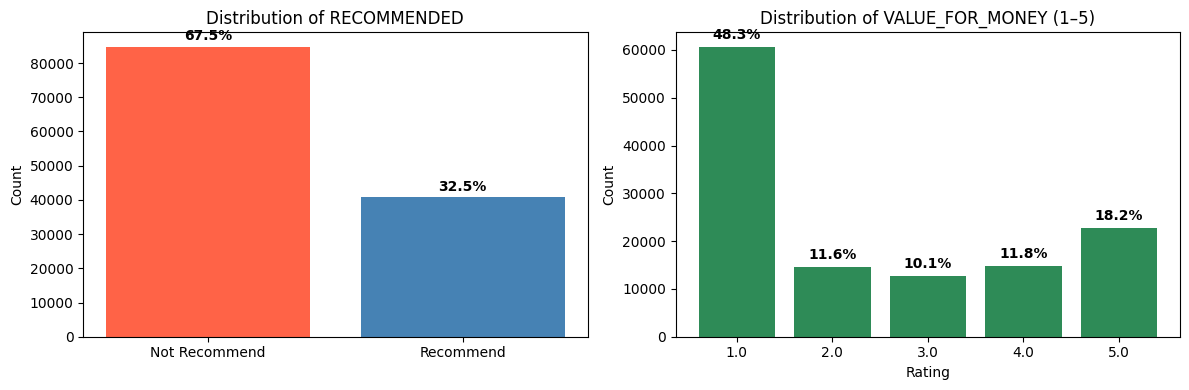

In [104]:
def plot_target_distribution(df, target_col, feature_col):
    """
    Plots the distribution of target variables RECOMMENDED and VALUE_FOR_MONEY
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Target classification column "RECOMMENDED" distribution
    target_counts = df[target_col].value_counts().sort_index()
    bars = axes[0].bar(["Not Recommend", "Recommend"], 
                       target_counts, 
                       color=["tomato", "steelblue"]
    )
    axes[0].set_title("Distribution of RECOMMENDED")
    axes[0].set_ylabel("Count")

    for bar, count in zip(bars, target_counts):
        pct = f"{count / target_counts.sum() * 100:.1f}%"
        axes[0].text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_height() + 1000,
            pct,
            ha="center", va="bottom",
            fontsize=10, fontweight="bold"
        )

    # Target regression column "VALUE_FOR_MONEY" distribution
    feature_counts = df[feature_col].value_counts().sort_index()
    bars = axes[1].bar(
        feature_counts.index.astype(str), 
        feature_counts.values, 
        color="seagreen"
    )
    axes[1].set_title("Distribution of VALUE_FOR_MONEY (1–5)")
    axes[1].set_xlabel("Rating")
    axes[1].set_ylabel("Count")

    for bar, count in zip(bars, feature_counts):
        pct = f"{count / feature_counts.sum() * 100:.1f}%"
        axes[1].text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_height() + 1000,
            pct,
            ha="center", va="bottom",
            fontsize=10, fontweight="bold"
        )

    plt.tight_layout()
    plt.show()

# Plot distributions
plot_target_distribution(df_eda, TARGET_COL, TARGET_REG)


About **67.5% of passengers do not recommend** their flights, while only **32.5% would recommend**, indicating overall dissatisfaction.  
For **Value for Money**, nearly **half of the reviews (48.3%) rated 1**, with relatively few high scores.  
This suggests that passengers generally perceive **low value relative to cost**, aligning with the low recommendation rate.

### 1.3.2. Numeric Distributions

                           count      mean       std  min   5%  25%  50%  \
SEAT_COMFORT            125457.0  2.526499  1.423344  1.0  1.0  1.0  2.0   
CABIN_STAFF_SERVICE     125457.0  2.842552  1.549411  1.0  1.0  1.0  3.0   
FOOD_AND_BEVERAGES       88429.0  2.565799  1.517850  1.0  1.0  1.0  2.0   
INFLIGHT_ENTERTAINMENT   70821.0  2.525014  1.521404  1.0  1.0  1.0  2.0   
GROUND_SERVICE          125457.0  2.248675  1.572180  1.0  1.0  1.0  1.0   
WIFI_AND_CONNECTIVITY    41138.0  1.926127  1.402706  1.0  1.0  1.0  1.0   
VALUE_FOR_MONEY         125457.0  2.398742  1.591520  1.0  1.0  1.0  2.0   
AVERAGE_RATING          125457.0  2.426677  1.374939  1.0  1.0  1.0  2.0   

                         75%   95%  max  
SEAT_COMFORT            4.00  5.00  5.0  
CABIN_STAFF_SERVICE     4.00  5.00  5.0  
FOOD_AND_BEVERAGES      4.00  5.00  5.0  
INFLIGHT_ENTERTAINMENT  4.00  5.00  5.0  
GROUND_SERVICE          4.00  5.00  5.0  
WIFI_AND_CONNECTIVITY   3.00  5.00  5.0  
VALUE_FOR_MONEY      

<Figure size 1200x800 with 0 Axes>

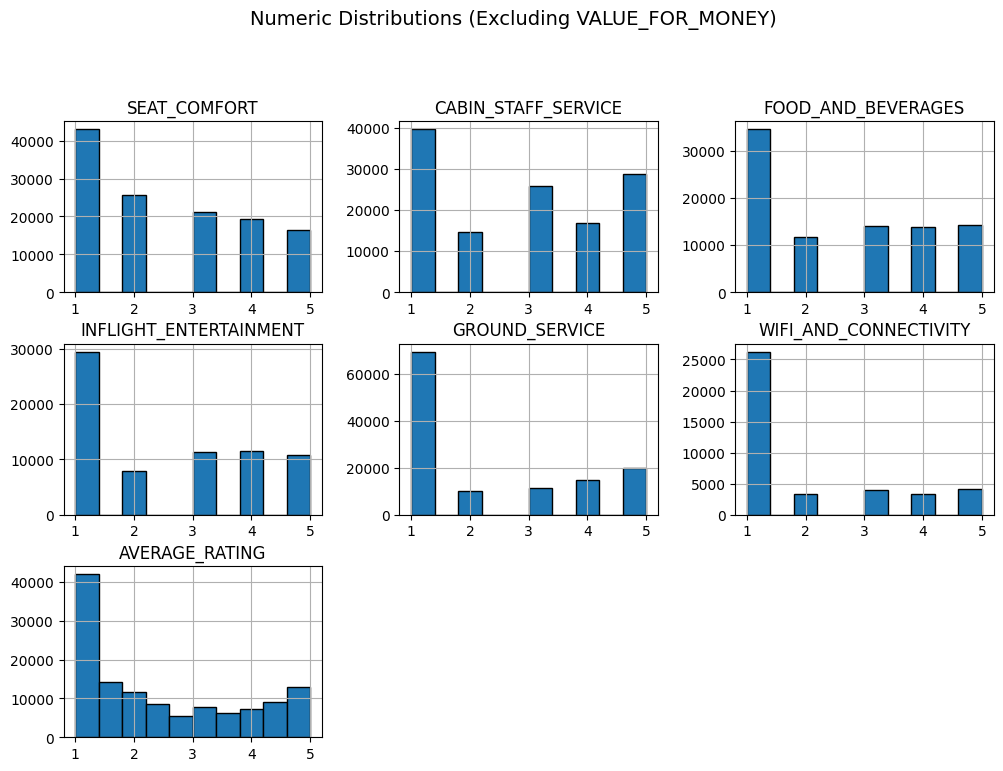

In [105]:
# Describe numeric distributions
print(df_eda[NUMERIC_COLS].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T)

# Plot numeric distributions
def plot_numeric_distributions(df):
    numeric_no_target = [col for col in NUMERIC_COLS if col != TARGET_REG]
    plt.figure(figsize=(12, 8))
    df[numeric_no_target].hist(bins=10, figsize=(12, 8), edgecolor="black")
    plt.suptitle("Numeric Distributions (Excluding VALUE_FOR_MONEY)", y=1.02, fontsize=14)
    plt.show()

plot_numeric_distributions(df_eda)

Service ratings range from **1–5**, with medians around **2–3**, indicating moderate satisfaction overall.  
**Cabin staff** and **food & beverages** score higher, while **ground service** and **Wi-Fi** rate lower.  
The **average rating** (~2.4) aligns with other features, showing consistent customer feedback.

### 1.3.3. Categorical Distributions

SEAT_TYPE distribution:
                   count
SEAT_TYPE              
Economy Class    104376
Business Class    14099
Premium Economy    4844
First Class        2138 

TYPE_OF_TRAVELLER distribution:
                    count
TYPE_OF_TRAVELLER       
Solo Leisure       48618
Couple Leisure     31215
Family Leisure     27923
Business           17701 

RATING_BAND distribution:
              count
RATING_BAND       
bad          60178
medium       37518
good         27745
Unknown         16 

AIRLINE distribution:
                              count
AIRLINE                           
Read more                     6051
American Airlines             5863
Spirit Airlines               4645
Spirit Airlines5272 Reviews   4634
United Airlines               4532 



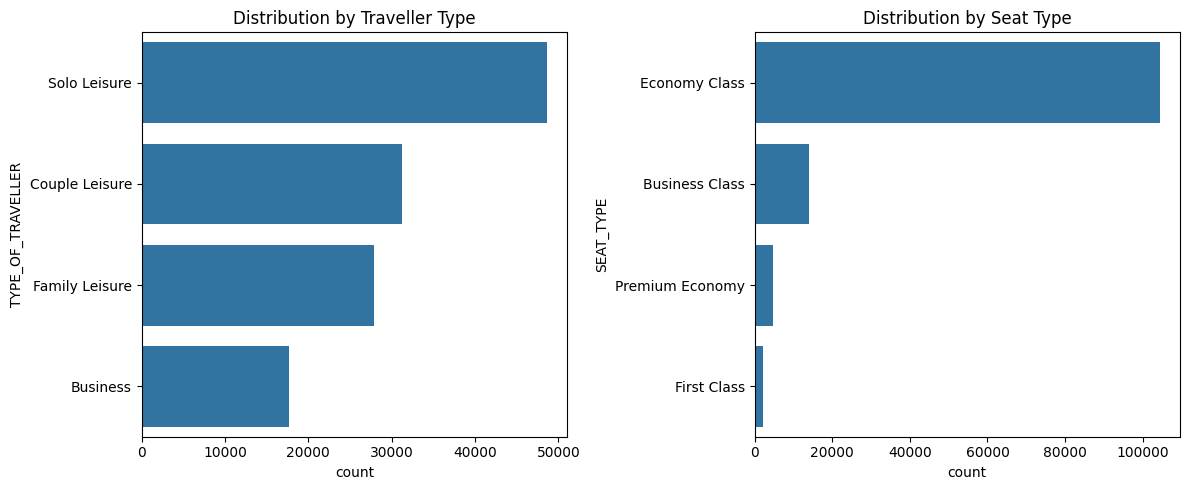

In [106]:
# Categorical distributions
seg_counts = {}
for cname in CATEGORICAL_COLS:
    seg_counts[cname] = (
        df_eda[cname].fillna("<NULL>").value_counts().to_frame("count")
    )
for cname in seg_counts:
    print(f"{cname} distribution:\n", seg_counts[cname].head(), "\n")

# Plot selected categorical distributions
def plot_categorical_distributions(df):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes = axes.flatten()
    # Traveller type
    sns.countplot(
        y=df["TYPE_OF_TRAVELLER"],
        order=df["TYPE_OF_TRAVELLER"].value_counts().index,
        ax=axes[0]
    )
    axes[0].set_title("Distribution by Traveller Type")
    # Seat type
    sns.countplot(
        y=df["SEAT_TYPE"],
        order=df["SEAT_TYPE"].value_counts().index,
        ax=axes[1]
    )
    axes[1].set_title("Distribution by Seat Type")
    plt.tight_layout()
    plt.show()

plot_categorical_distributions(df_eda)

Most reviews come from **Economy Class** travelers, followed by **Business Class**, while higher classes form a small share.  
The majority of passengers are **Solo** or **Couple Leisure** travelers, with fewer **Family** and **Business** types.  
Ratings are mostly **bad** or **medium**, indicating moderate satisfaction levels overall.  
A wide variety of **airlines** are represented, with some appearing under slightly different name formats.

## **2. Business-Relevant Questions**

### 2.1. Which features have the strongest correlation with VALUE_FOR_MONEY and RECOMMENDED?

We explored how service-related ratings (seat comfort, staff service, food, etc.) correlate with the two key target variables. A correlation heatmap was computed across all numeric features and targets:  

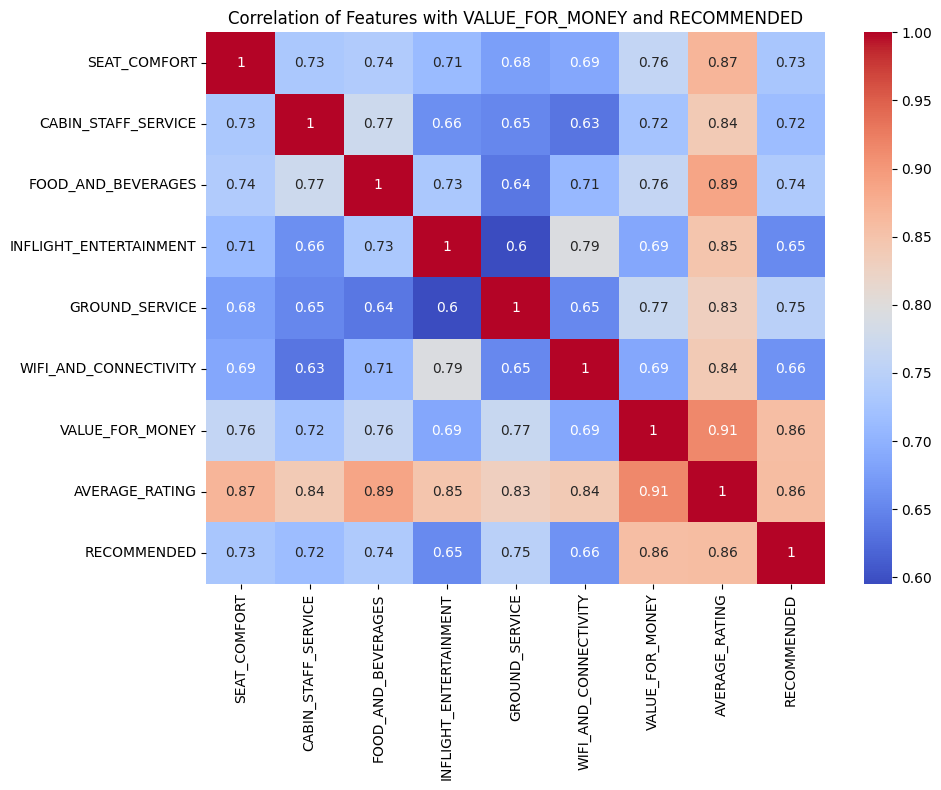

In [120]:
corr_df = df_eda.copy()

# Compute correlation 
corr_matrix = (
    corr_df[list(dict.fromkeys(NUMERIC_COLS + ["VALUE_FOR_MONEY", "RECOMMENDED"]))] # Dedupe because VALUE_FOR_MONEY is already in NUMERIC_COLS
    .corr()
)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation of Features with VALUE_FOR_MONEY and RECOMMENDED")
plt.tight_layout()
plt.show()


All service ratings show **strong positive correlations** with both **Value for Money** and **Recommended**, suggesting overall consistency in customer perceptions.  
**Average Rating** has the highest correlation with both targets (≈0.9), indicating it captures overall satisfaction well.  
Among individual service factors, **Food & Beverages**, **Seat Comfort**, and **Cabin Staff Service** are most closely associated with higher value perception and likelihood to recommend.  
**Wi-Fi** and **Ground Service** show slightly weaker, though still positive, relationships with satisfaction outcomes.

### 2.2. Categorical features vs Target

### 2.2.1. Categorical features vs 'RECOMMENDED'

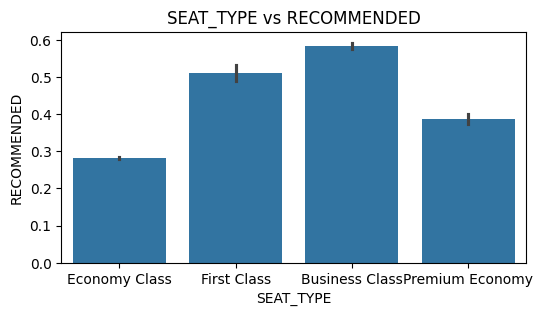

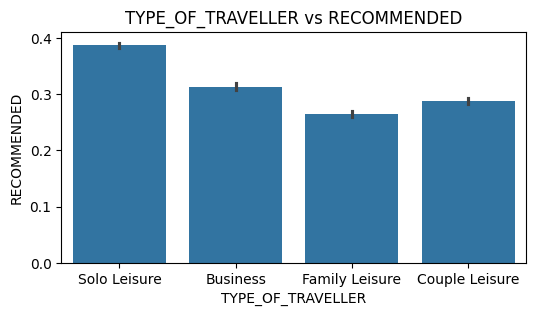

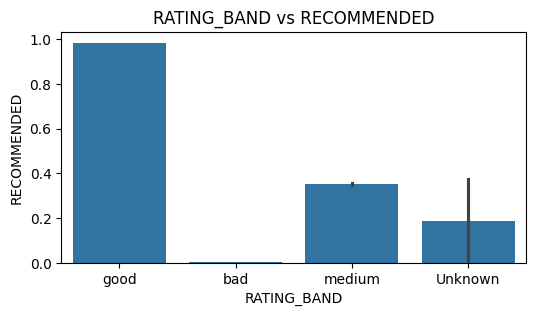

In [108]:
# Bar plots for categorical features vs RECOMMENDED
for col in CATEGORICAL_COLS:
    if col == "AIRLINE":
        continue
    plt.figure(figsize = (6,3))
    sns.barplot(x = df_eda[col], y = df_eda[TARGET_COL])
    plt.title(f"{col} vs RECOMMENDED")
    plt.show()

### 2.2.2. Categorical features vs 'VALUE_FOR_MONEY'

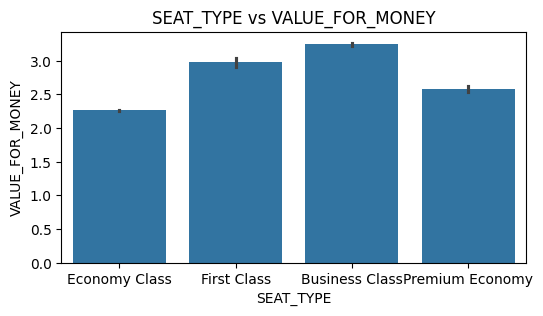

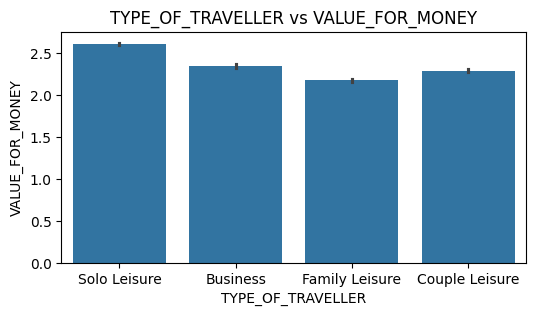

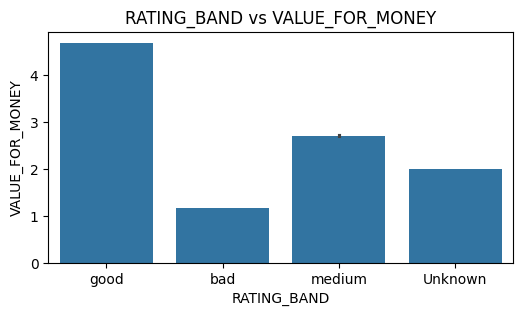

In [132]:
# Bar plots for categorical features vs VALUE_FOR_MONEY
for col in CATEGORICAL_COLS:
    if col == "AIRLINE":
        continue
    plt.figure(figsize = (6,3))
    sns.barplot(x = df_eda[col], y = df_eda[TARGET_REG])
    plt.title(f"{col} vs VALUE_FOR_MONEY")
    plt.show()

### Categorical Features vs VALUE_FOR_MONEY and RECOMMENDED

Passengers in **Business Class** and **First Class** consistently report higher **value for money** and are more likely to **recommend** their flights, while **Economy Class** travelers express the lowest satisfaction in both areas.  
Across traveller types, **Solo Leisure** passengers perceive the greatest value and show the highest likelihood of recommendation, compared to **Family**, **Couple**, and **Business** travellers.  
In terms of overall satisfaction, those with a **good rating band** strongly associate with high value-for-money scores and almost always recommend their flights, whereas **bad** and **medium** ratings correspond to low satisfaction and recommendation levels.  
Overall, these patterns indicate that **travel class, traveller type, and overall satisfaction** are key factors shaping both **perceived value** and **recommendation behavior**.

### 2.3. Numerical features vs Target

### 2.3.1. Numeric features vs 'RECOMMENDED'

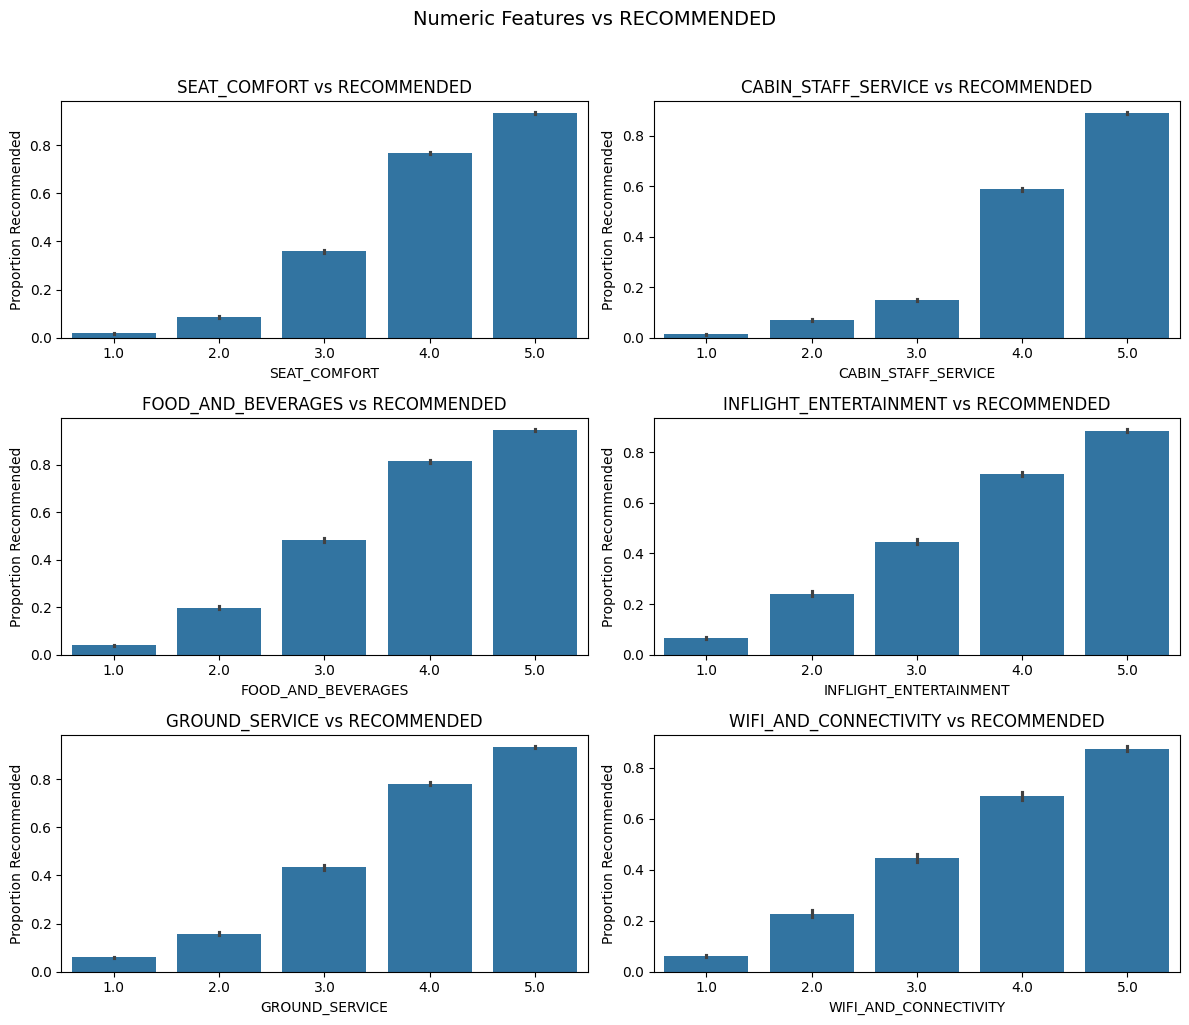

In [ ]:
# Bar plots for numeric features vs RECOMMENDED

def plot_numeric_recommended(df):
    numeric_no_target = [col for col in NUMERIC_COLS if col not in ["VALUE_FOR_MONEY", "AVERAGE_RATING"]]
    fig, axes = plt.subplots(3, 2, figsize=(12, 10))
    axes = axes.flatten()
    for i, col in enumerate(numeric_no_target):
        sns.barplot(x=df[col], y=df["RECOMMENDED"], ax=axes[i])
        axes[i].set_title(f"{col} vs RECOMMENDED")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Proportion Recommended")
    plt.suptitle("Numeric Features vs RECOMMENDED", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

plot_numeric_recommended(df_eda)

### 2.3.2. Numeric features vs 'VALUE_FOR_MONEY'

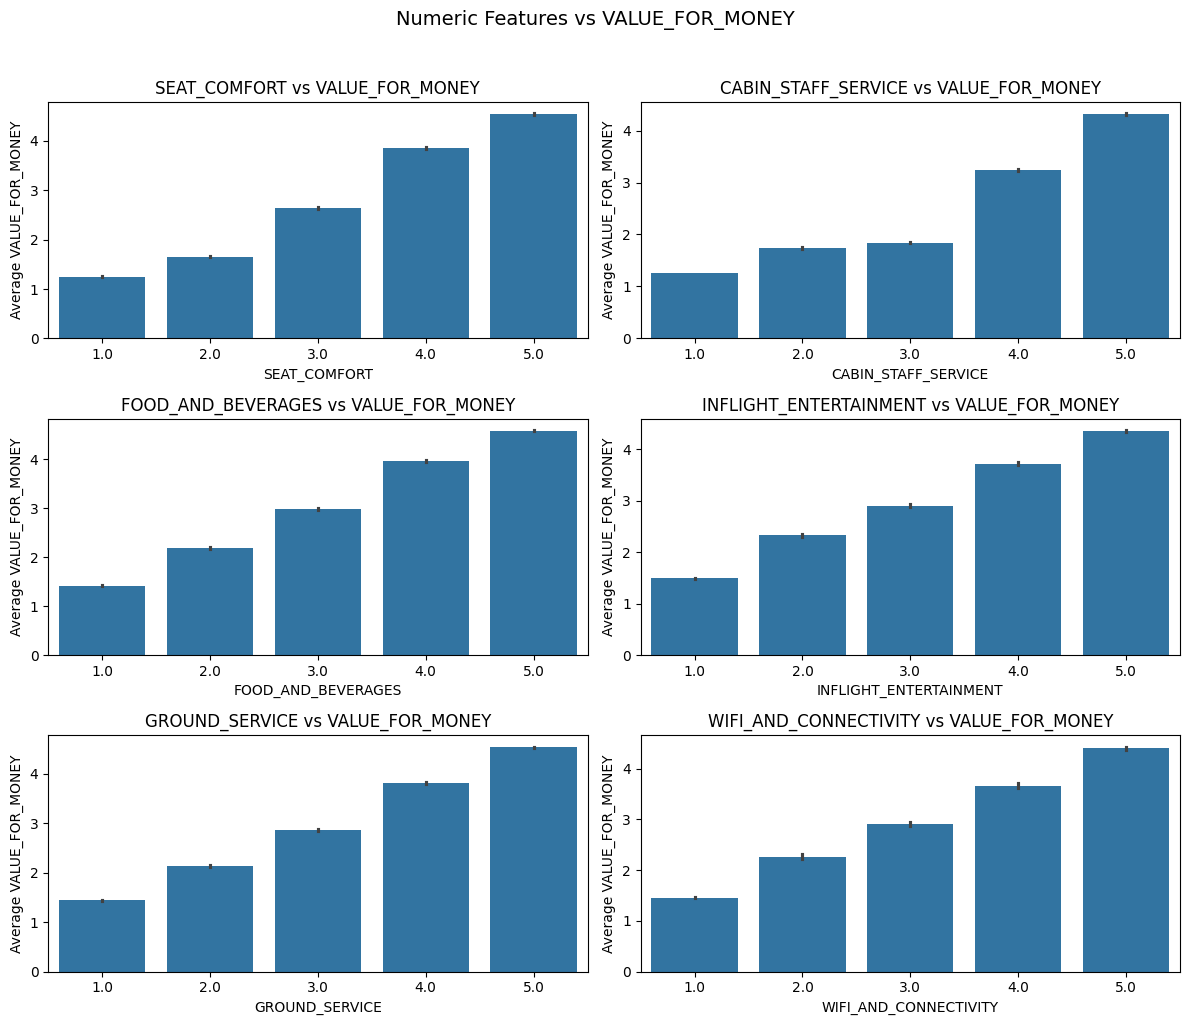

In [ ]:
# Bar plots for numeric features vs VALUE_FOR_MONEY

def plot_numeric_value(df):
    numeric_no_target = [col for col in NUMERIC_COLS if col not in ["VALUE_FOR_MONEY", "AVERAGE_RATING"]]
    fig, axes = plt.subplots(3, 2, figsize=(12, 10))
    axes = axes.flatten()
    for i, col in enumerate(numeric_no_target):
        sns.barplot(x=df[col], y=df["VALUE_FOR_MONEY"], ax=axes[i])
        axes[i].set_title(f"{col} vs VALUE_FOR_MONEY")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Average VALUE_FOR_MONEY")
    plt.suptitle("Numeric Features vs VALUE_FOR_MONEY", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

plot_numeric_value(df_eda)

### Numeric Features vs VALUE_FOR_MONEY and RECOMMENDED

All service-related numeric features display a strong **positive relationship** with both **perceived value for money** and **likelihood to recommend**.  
As ratings for **Seat Comfort**, **Cabin Staff Service**, **Food & Beverages**, **In-flight Entertainment**, **Ground Service**, and **Wi-Fi & Connectivity** increase, passengers consistently report higher value perceptions and are far more likely to recommend the airline.  
The trend is especially pronounced for top scores (4–5), highlighting that **enhancing service quality directly improves perceived value and customer advocacy**, making these areas key drivers of overall satisfaction.

## **3. Modelling**

### 3.1. Regression (VALUE_FOR_MONEY)
Model question: *How much value for money will a passenger perceive given their experience across service dimensions?*
Models: LinearRegression, RandomForestRegressor, XGBoostRegressor
Evaluation: RMSE, MAE, and R²

### 3.2. Classification (RECOMMENDED)
Model question: *Given their service ratings and travel context, will a passenger recommend the airline?*
Models: LogisticRegression, RandomForestClassifier, XGBoostClassifier
Evaluation: Accuracy, Precision, Recall, F1-score, ROC-AUC